In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch

/Users/abhishek.sawalkar/opt/anaconda3/envs/ml3/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator

/Users/abhishek.sawalkar/opt/anaconda3/envs/ml3/lib/python3.6/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


In [3]:
from pts.model.tempflow import TempFlowEstimator
from pts.model.time_grad import TimeGradEstimator
from pts.model.transformer_tempflow import TransformerTempFlowEstimator
from pts import Trainer

In [4]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device=torch.device("cpu")

In [5]:
def plot(target, forecast, prediction_length, prediction_intervals=(50.0, 90.0), color='g', fname=None):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape
    
    ps = [50.0] + [
            50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
        ]
        
    percentiles_sorted = sorted(set(ps))
    
    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3
        
    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)
        
        ps_data = [forecast.quantile(p / 100.0)[:,dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2
        
        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)
        
        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]    
    axx[0].legend(legend, loc="upper left")
    
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0.05)

In [6]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5']


In [7]:
# exchange_rate_nips, electricity_nips, traffic_nips, solar_nips, wiki-rolling_nips, ## taxi_30min is buggy still
dataset = get_dataset("covid_deaths", regenerate=False)

In [8]:
train_grouper = MultivariateGrouper(max_target_dim=min(2000, int(dataset.metadata.feat_static_cat[0].cardinality)))

test_grouper = MultivariateGrouper(num_test_dates=int(len(dataset.test)/len(dataset.train)), 
                                   max_target_dim=min(2000, int(dataset.metadata.feat_static_cat[0].cardinality)))

In [9]:
dataset_train = train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)

In [10]:
print(type(dataset_train))
print(type(dataset_test))
print("Prediction length:",dataset.metadata.prediction_length)
print(dataset.metadata.freq)
print(dataset.metadata.feat_static_cat[0].cardinality)
print(len(dataset_train))

gluonts.dataset.common.ListDataset
gluonts.dataset.common.ListDataset
Prediction length: 30
D
266
1


In [13]:
estimator = TimeGradEstimator(
    target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length,
    cell_type='GRU',
    input_size=1066,
    freq=dataset.metadata.freq,
    loss_type='l2',
    scaling=True,
    diff_steps=100,
    beta_end=0.1,
    beta_schedule="linear",
    trainer=Trainer(device=device,
                    epochs=1,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100,
                    batch_size=16,)
)

In [14]:
predictor = estimator.train(dataset_train, num_workers=8)

100%|██████████| 99/99 [01:46<00:00,  1.08s/it, epoch=1/1, avg_loss=0.458]


In [15]:
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                                 predictor=predictor,
                                                 num_samples=100)

In [16]:
forecasts = list(forecast_it)
targets = list(ts_it)

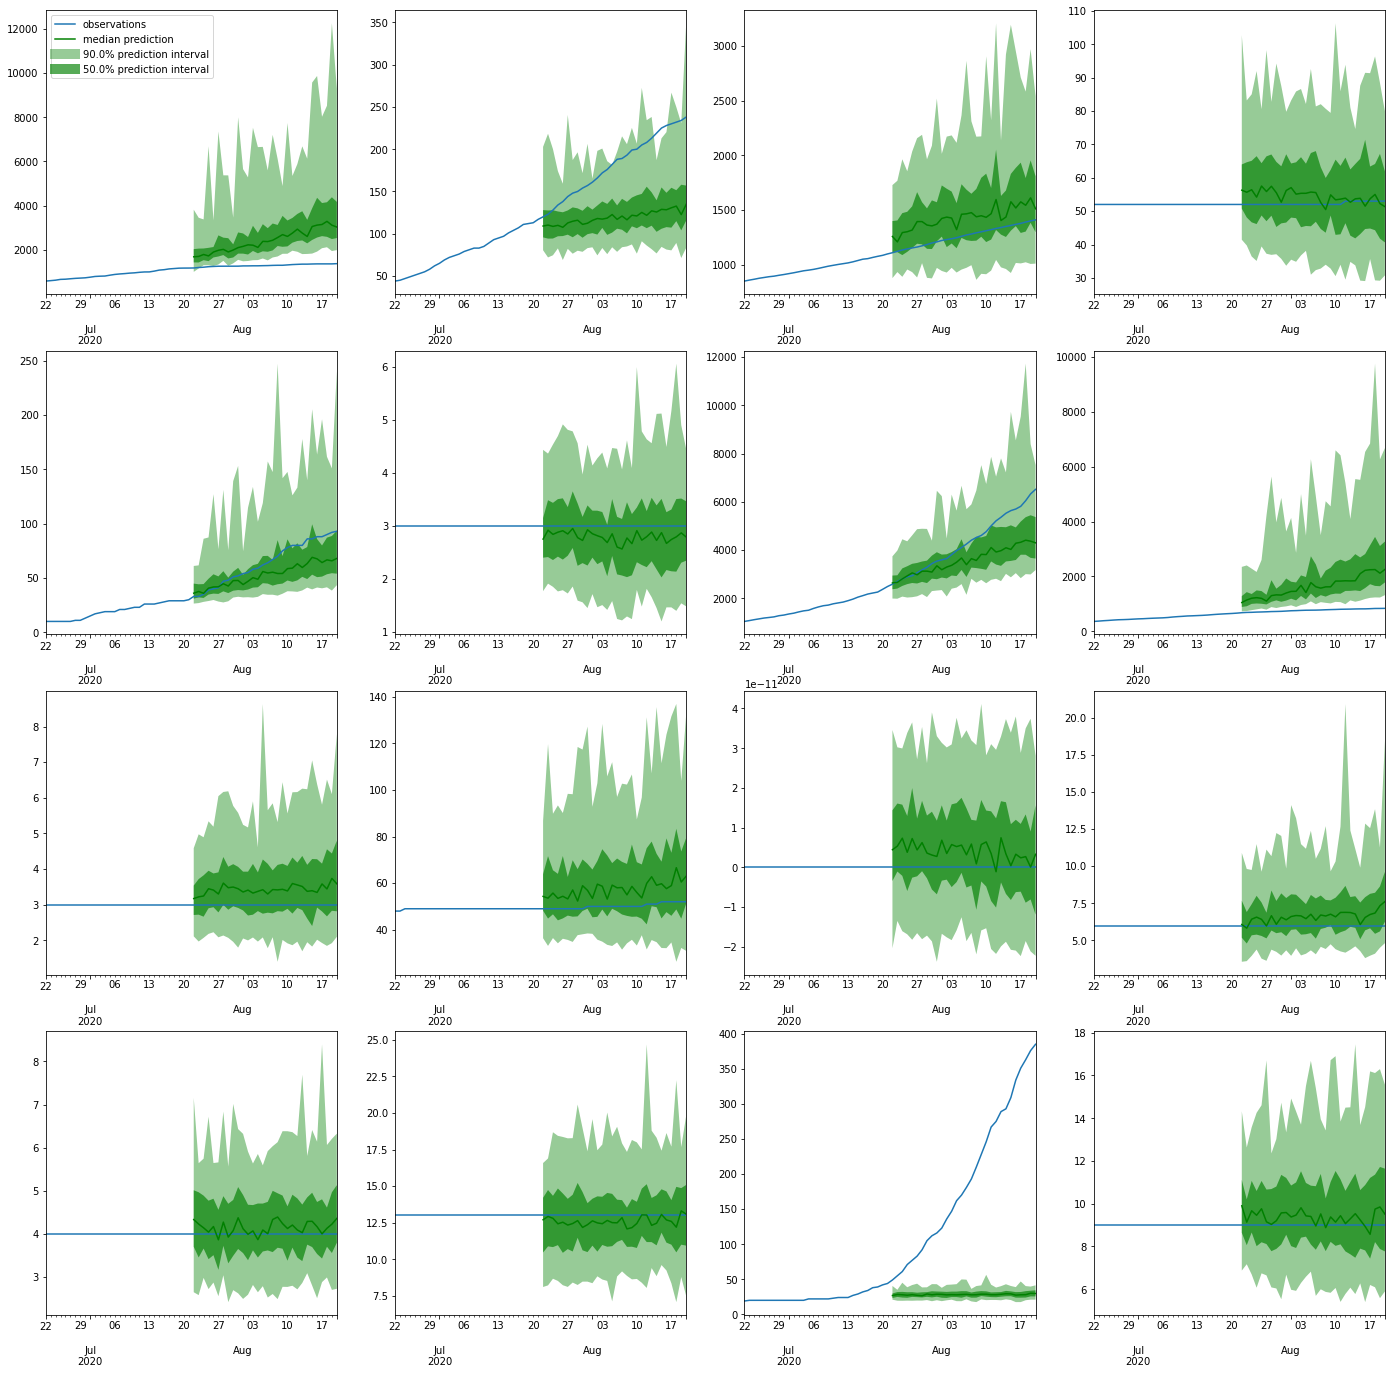

In [17]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=dataset.metadata.prediction_length,
)
plt.show()

In [31]:
evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:], 
                                  target_agg_funcs={'sum': np.sum})

In [34]:
agg_metric, item_metrics = evaluator(targets, forecasts, num_series=len(dataset_test))

Running evaluation: 7it [00:00, 114.59it/s]
Running evaluation: 7it [00:00, 121.35it/s]
Running evaluation: 7it [00:00, 122.29it/s]
Running evaluation: 7it [00:00, 140.38it/s]
Running evaluation: 7it [00:00, 117.49it/s]
Running evaluation: 7it [00:00, 131.90it/s]
Running evaluation: 7it [00:00, 127.43it/s]
Running evaluation: 7it [00:00, 134.13it/s]
Running evaluation: 7it [00:00, 139.43it/s]
Running evaluation: 7it [00:00, 141.24it/s]
Running evaluation: 7it [00:00, 142.65it/s]
Running evaluation: 7it [00:00, 143.82it/s]
Running evaluation: 7it [00:00, 130.78it/s]
Running evaluation: 7it [00:00, 122.90it/s]
Running evaluation: 7it [00:00, 126.49it/s]
Running evaluation: 7it [00:00, 120.90it/s]
Running evaluation: 7it [00:00, 123.20it/s]
Running evaluation: 7it [00:00, 138.06it/s]
Running evaluation: 7it [00:00, 139.31it/s]
Running evaluation: 7it [00:00, 128.41it/s]
Running evaluation: 7it [00:00, 131.50it/s]
Running evaluation: 7it [00:00, 140.73it/s]
Running evaluation: 7it [00:00, 

In [35]:
print("CRPS:", agg_metric["mean_wQuantileLoss"])
print("ND:", agg_metric["ND"])
print("NRMSE:", agg_metric["NRMSE"])
print("")
print("CRPS-Sum:", agg_metric["m_sum_mean_wQuantileLoss"])
print("ND-Sum:", agg_metric["m_sum_ND"])
print("NRMSE-Sum:", agg_metric["m_sum_NRMSE"])

CRPS: 0.3995612951169966
ND: 0.4921709335280122
NRMSE: 1.000499704665733

CRPS-Sum: 0.35684790344519185
ND-Sum: 0.3918344042344781
NRMSE-Sum: 0.7192430744690012
